We received the Total cost sheet and it looks like a Cubic function,  assumes you’re modeling a function similar to a*x^3 + b*x^2 + c*x + d, where x is transformed to include its squared and cubic terms before being fed into a single nn.Linear layer.

### Step 1: Import Necessary Libraries


In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

### Step 2: Define the Cubic Cost Model

In [155]:
class CubicCostModel(nn.Module): 
    def __init__(self) : 
        super(CubicCostModel,self).__init__()
      # Linear layer with 3 input features (x, x^2, x^3) and 1 output (total cost)
      # x is the Quantity Produced
        self.fc = nn.Linear(3,1)
    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        # Transform input to include cubic and squared terms
        # x_poly =torch.cat([x, x**2, x**3], dim = 1)
        # Pass transformed input through linear layer
        return self.fc(x)

### Step 3: Initialize the Model, Define Loss, and Optimizer

In [156]:
# Initialize the model 
model=CubicCostModel()
# Mean Square Error Loss for regression
loss_fn = nn.MSELoss()
#optimizer ( we can use SGD Stochastic Gradient Descent or Adam )
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Step 4: Prepare the Data


In [157]:
def transformDataToPoly(data):
  # Transform data to include polynomial terms
  x_data_poly = torch.cat([data, data**2, data**3], dim=1)
  return x_data_poly  

In [158]:
file_path = "revenue2-2.xlsx"
df = pd.read_excel(file_path)
# df.dtypes #to check the datatype to convert to torch datatype
Q = df['Quntitys Produced']  # int64
Q_max = Q.max()
# print(Q_max)
Q = Q / Q_max
tc = df['Total cost']     # float64
tc = tc / pow(Q_max,3)
X = torch.tensor(Q , dtype= torch.float32).unsqueeze(1) 
y = torch.tensor(tc , dtype= torch.float32).unsqueeze(1)

# create train/test split 
train_split = int(0.8 * len(X))
X_train , y_train = X[ :train_split], y[ :train_split]
X_test = X[train_split : ]
y_test = y[train_split: ]

X_train_poly = transformDataToPoly(X_train)
X_test_poly =transformDataToPoly(X_test)
len(X_train) , len(y_train), len(X_test) , len(y_test) , len(X_train_poly)

(118, 118, 30, 30, 118)

### Step 5: Training Loop

In [159]:
epochs = 1000
for epoch in range(epochs):
    #Training 
    #put the model in training mode 
    model.train()
    #1.forward pass 
    y_pred = model(X_train_poly) 
    #2.calculate the loss 
    loss = loss_fn(y_pred, y_train)
    #3. Zero grad of the optimizer 
    optimizer.zero_grad()
    #4. loss backwards -->>> loss.backward() computes dloss/dx for every parameter x which has requires_grad=True.
    loss.backward()  
    #5. Progress the optimizer
    optimizer.step()
    
    # print progress
    if (epoch+1) % 200 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.5f}')

Epoch [200/1000], Loss: 0.00000
Epoch [400/1000], Loss: 0.00000
Epoch [600/1000], Loss: 0.00000
Epoch [800/1000], Loss: 0.00000
Epoch [1000/1000], Loss: 0.00000


### Step 6: Model Evaluation

In [160]:
model.eval()
with torch.no_grad():
     y_preds = model(X_test_poly)

In [161]:
# Sample prediction
with torch.no_grad():
    
    test_data81 = torch.tensor([[81/Q_max]], dtype=torch.float32)
    test_data_poly81 = torch.cat([test_data81, test_data81**2, test_data81**3], dim=1)
    y_pred_at_81= model(test_data_poly81)
    print(f"Predicted cost for input : { y_pred_at_81.item()*pow(Q_max,3):.4f}")


Predicted cost for input : 8627.1309


In [199]:
def plotData(x_axis, y1_axis, label1 ,  y2_test,test_data=None,predictions=None ):

    x_axis=x_axis.detach().numpy()
    y1_axis=y1_axis.detach().numpy()
      
    plt.scatter(x_axis, y1_axis, c ="b" , s= 4, label = label1 )
    plt.scatter(test_data, y2_test, c ="g" , s= 4, label = label1 )
        
    if predictions != None:
      # Extract values to 1D arrays
      test_data=test_data.detach().numpy()
      # predictions=predictions.detach.numpy()  
      plt.scatter(test_data, predictions, c = "r" , s= 4, label = "prediction" )

      i = int((len(test_data)+len(x_axis))/2)
      # Specify the point to annotate
      x_value =  i
      y_value = predictions.max()*0.8
    
      # Annotate the point on the curve
      plt.annotate(
        'prediction', # The text to display
        xy=(x_value*1.8, y_value), # The point to annotate
        xytext=(x_value  , y_value), # Position of the text
        arrowprops=dict(arrowstyle='->', color='black'), # Arrow properties
        fontsize=10, # Font size
        color='red' # Text color 
              )
    
    plt.legend()
    plt.show()

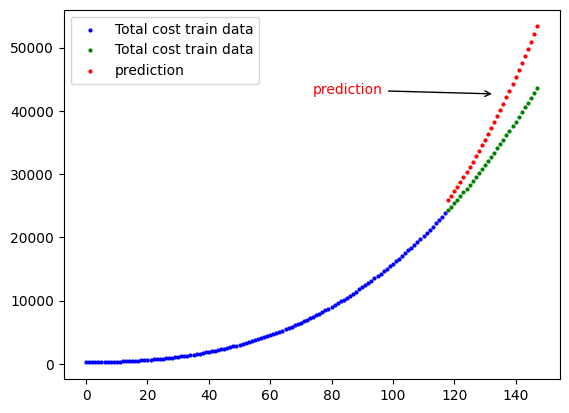

In [200]:
plotData(X_train*Q_max,y_train*pow(Q_max,3),label1="Total cost train data",y2_test=y_test*pow(Q_max,3), test_data=X_test*Q_max,predictions=y_preds*pow(Q_max,3))

In [184]:
print("Test data shape:", test_data.shape)
print("Predictions shape:", y_pred.shape)
print("Test data shape:", test_data.size())
print("Predictions shape:", y_pred.size())

Test data shape: torch.Size([1, 1])
Predictions shape: torch.Size([118, 1])
Test data shape: torch.Size([1, 1])
Predictions shape: torch.Size([118, 1])


### Saving a PyTorch model's in pt 


In [202]:
MODEL_SAVE_PATH = "cubicModel.pt"
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

In [203]:
model.state_dict()

OrderedDict([('fc.weight', tensor([[ 0.0085, -0.0214,  0.0302]])),
             ('fc.bias', tensor([-0.0005]))])